# LSTM Model - AAPL Stock Prices
Sarah Sullivan

Created: May 2023

Last Updated: October 9, 2023

## Program Setup

Import relevant modules

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose

from numpy import arange
from pandas import read_csv
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor

Read in data, sourced from https://www.nasdaq.com/market-activity/stocks/aapl/historical

In [5]:
url = "https://raw.githubusercontent.com/sarahbsullivan/lstm-model-S23/main/Apple_Data.csv"
df = pd.read_csv(url)

In [6]:
shape = df.shape
print("The data contains observations on",shape[1], "features of AAPL stock for", shape[0], "dates.""\n""The measured features are Opening Price for that day, Highest Price on that day, Lowest Price on that day, Closing Price for that day, and Volume sold that day.""\n""The data have 6 columns, suggesting 6 features. However, the first column gives the date. We will later reindex the data to remove this column and return a date-time index instead.")

The data contains observations on 6 features of AAPL stock for 1257 dates.
The measured features are Opening Price for that day, Highest Price on that day, Lowest Price on that day, Closing Price for that day, and Volume sold that day.
The data have 6 columns, suggesting 6 features. However, the first column gives the date. We will later reindex the data to remove this column and return a date-time index instead.


In [7]:
# Remove $ characters and convert observations to float values
varlist = ["Close/Last", "Open", "High", "Low"]
for i in varlist:
    df[i] = df[i].str.replace("$",'', regex=True).astype(float)

Check for null values to avoid outliers in training.

In [8]:
print("Null Values?:", df.isnull().values.any())
print("If there were missing values in the data, we would need to remove these observations or interpolate to find a valid estimate for them.")

Null Values?: False
If there were missing values in the data, we would need to remove these observations or interpolate to find a valid estimate for them.


Isolate observations in the timeframe 2021-2022

In [9]:
# Define df_apple as a dataframe containing observations from 2021-20022
df_apple = df[df["Date"].str.contains("2021|2022")]
# Reindex df_apple to use a date-time index in chronological order.
df_apple = df_apple.loc[::-1].reset_index(drop=True)
df_apple = df_apple.set_index(pd.DatetimeIndex(df_apple['Date']))
df_apple['Date'] = pd.to_datetime(df_apple.Date, format="%m/%d/%Y")

Observe new dataframe.

In [10]:
df_apple.head(-2)

,Date,Close/Last,Volume,Open,High,Low
Date,,,,,,
2021-01-04,2021-01-04,129.41,143301900,133.520,133.6116,126.760
2021-01-05,2021-01-05,131.01,97664900,128.890,131.7400,128.430
2021-01-06,2021-01-06,126.60,155088000,127.720,131.0499,126.382
2021-01-07,2021-01-07,130.92,109578200,128.360,131.6300,127.860
2021-01-08,2021-01-08,132.05,105158200,132.430,132.6300,130.230
...,...,...,...,...,...,...
2022-12-21,2022-12-21,135.45,85927990,132.980,136.8100,132.750
2022-12-22,2022-12-22,132.23,77852110,134.352,134.5600,130.300
2022-12-23,2022-12-23,131.86,63814890,130.920,132.4150,129.640


In [17]:
shape = df_apple.shape

In [18]:

print("There are", shape[0],"dates with observed price data during the years 2021 and 2022")
print("After reindexing, our data now contains only 5 explanatory features: Close/Last Price, Volume, Opening Price, Highest Price, and Lowest Price for a given date.""\n""The 6th feature is the given date.")

There are 503 dates with observed price data during the years 2021 and 2022
After reindexing, our data now contains only 5 explanatory features: Close/Last Price, Volume, Opening Price, Highest Price, and Lowest Price for a given date.
The 6th feature is the given date.


In [14]:
print(df_apple.describe())

       Close/Last        Volume        Open        High         Low
count  503.000000  5.030000e+02  503.000000  503.000000  503.000000
mean   147.898429  8.923537e+07  147.818085  149.613199  146.069436
std     15.503697  2.658691e+07   15.449531   15.662776   15.286482
min    116.360000  3.519586e+07  119.030000  120.403100  116.210000
25%    135.380000  7.091765e+07  135.745000  137.025000  133.750000
50%    147.060000  8.450576e+07  147.030000  148.820000  145.630000
75%    159.260000  1.022806e+08  159.577500  161.970000  156.626400
max    182.010000  1.959234e+08  182.630000  182.940000  179.120000


In [15]:
print("Mean values for Close, Open, High, and Low prices show that the average value for AAPL stock fell between $147 and $149 in 2021 and 2022.""\n""Minima and maxima reveal that AAPL stock reached prices as low as $116 and as high as $182 during this timeframe.")

Mean values for Close, Open, High, and Low prices show that the average value for AAPL stock fell between $147 and $149 in 2021 and 2022.
Minima and maxima reveal that AAPL stock reached prices as low as $116 and as high as $182 during this timeframe.


Plot AAPL Closing Stock Prices from 1/1/2021 through 12/30/2022

<function matplotlib.pyplot.show(close=None, block=None)>

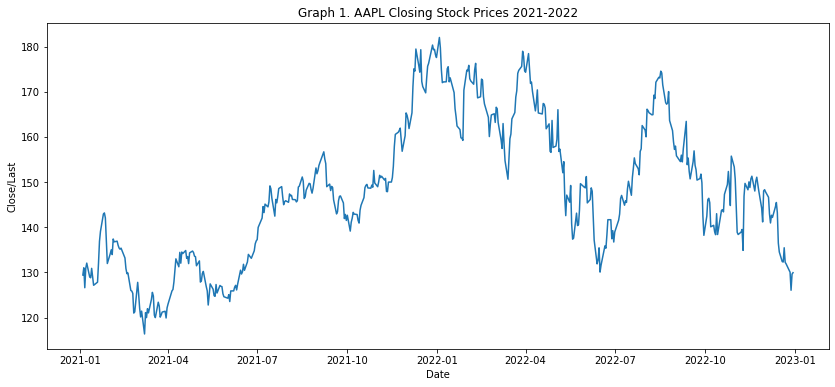

In [19]:
plt.figure(figsize = (14,6))
sns.lineplot(data=df_apple, x="Date", y="Close/Last")
plt.title("Graph 1. AAPL Closing Stock Prices 2021-2022")
plt.show

Decompose stock prices into trends, seasonality, and residuals to explain variation shown above

* The trend graph shows the overall movement of the stock price from 2021-2022.
* The seasonal graph returns any repeating patterns that occur over regular intervals, likely resulting from seasonal factors.
* The residual graph shows the "noise" or any irregular components in stock price fluctuations after controlling for trends and seasonal effects.

Graph 2. Seasonal Decomposition of Closing Stock Prices 2021-2022


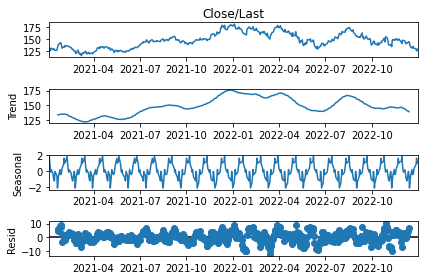

In [20]:
print("Graph 2. Seasonal Decomposition of Closing Stock Prices 2021-2022")
decomp = seasonal_decompose(x=df_apple['Close/Last'], period=24, model = 'additive')
decomp.plot()
plt.show()

In [21]:

print(
    "The trend portion of our decomposition shows that AAPL closing stock prices rose from a relative low in early 2021 to a relative high in early 2022, before declining again from 01/2022 to 06/2022."
    "\n""Closing stock prices then rose from 07/2022 to 09/2022, before declining again, albeit not reaching lows as severe as in early 2021."
    "\n""Seasonal fluctuations in stock prices can explain away some of the noise shown in the raw data given above."
    "\n""The presence of residual error suggests that stock prices sometimes fluctuated due to factors other than time."
    "\n""However, this observation is concordant with our knowledge of the stock market, where prices often fluctuate in response to extraneous variables.")

The trend portion of our decomposition shows that AAPL closing stock prices rose from a relative low in early 2021 to a relative high in early 2022, before declining again from 01/2022 to 06/2022.
Closing stock prices then rose from 07/2022 to 09/2022, before declining again, albeit not reaching lows as severe as in early 2021.
Seasonal fluctuations in stock prices can explain away some of the noise shown in the raw data given above.
The presence of residual error suggests that stock prices sometimes fluctuated due to factors other than time.
However, this observation is concordant with our knowledge of the stock market, where prices often fluctuate in response to extraneous variables.


## Modeling Time Series Data

Normalize data to begin fitting a predictive model

In [22]:
df_scaled = df_apple
for col in df_apple.columns:
    df_apple[col] = MinMaxScaler(feature_range = (0,1)).fit_transform(df_apple[col].to_numpy().reshape(-1,1))

In [23]:
scaler = MinMaxScaler(feature_range = (0,1))
df_scaled = scaler.fit_transform(df_apple)
# df_scaled gives the scaled, time indexed dataframe with observations from 2021 and 2022
df_scaled = pd.DataFrame(columns=df_apple.columns, data = df_scaled, index = df_apple.index)

Define target variables and features

In [24]:
# The target variable "Close/Last" is given by target_y
target_y = df_scaled['Close/Last']
# Convert target_y to a dataframe for visualization later
target_y_df = pd.DataFrame(data = target_y)

# Define features as the additional scaled observations in our dataset and store in the dataframe features_df
features = ['Date','Open','High','Low','Volume']
#features = ['Date','Volume']
features_df = df_scaled[features]
features_df = pd.DataFrame(columns=features, data=features_df, index=df_scaled.index)

Split the dataset into training and testing samples.

* We use the method TimeSeriesSplit from scikitlearn to divide our data
* TimeSeriesSplit takes into account the temporal aspect of time series data, prohibiting our model from training based on future predictions.

In [25]:
# Define n_splits = 3 to yield a 70-30 training/testing split
split = TimeSeriesSplit(n_splits=3)

# Loop through the data to produce four dataframes: X_train (70% of feature values), X_test (30% of feature values), y_train (70% of closing stock prices), and y_test (30% of closing stock prices)
for train_index, test_index in split.split(features_df):
        X_train, X_test = features_df[:len(train_index)], features_df[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = target_y_df[:len(train_index)], target_y_df[len(train_index): (len(train_index)+len(test_index))]

Plot the training/ testing split of closing AAPL stock prices during 2021 and 2022.

<function matplotlib.pyplot.show(close=None, block=None)>

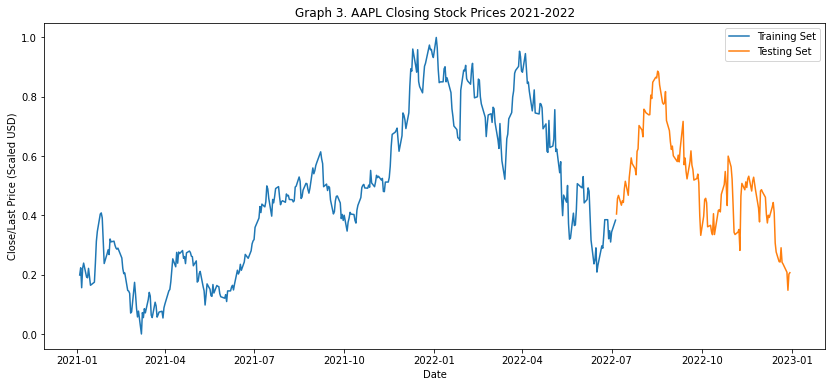

In [26]:
plt.figure(figsize = (14,6))

plt.plot(y_train['Close/Last'])
plt.plot(y_test['Close/Last'])
plt.xlabel('Date')
plt.ylabel('Close/Last Price (Scaled USD)')
plt.legend(['Training Set', 'Testing Set'])
plt.title("Graph 3. AAPL Closing Stock Prices 2021-2022")
plt.show

Reshape data for use in training the LSTM Model.

In [27]:
# Convert data to numpy arrays
y_train = np.array(y_train).ravel()
y_test = np.array(y_test).ravel()
X_train1 = np.array(X_train)
X_test1 = np.array(X_test)

In [28]:
# Reshape X_train and X_test to 3 dimensions for use in the LSTM model
X_train_array = X_train1.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_array = X_test1.reshape(X_test.shape[0], 1, X_test.shape[1])

In [29]:
# Verify shapes of training and testing arrays
print(X_train_array.shape)
print(X_test_array.shape)
print(y_test.shape)
print(y_train.shape)

(378, 1, 5)
(125, 1, 5)
(125,)
(378,)


Create and initialize the LSTM model

* The Long Short-Term Memory (LSTM) model is a Recurrent Neural Network (RNN). RNNs are effective in analyzing time series data, as they take the temporal aspect of the data into account, looking for sequential patterns.

* The sigmoid activation function is most commonly used in RNNs

* LSTM overcomes the vanishing gradient problem, where small inputs run through a sigmoid or tanh activation function produce exponentially small outputs, making the model difficult to train

* We define Mean Squared Error as our loss function, to be evaluated after training

* The Early Stopping Method can help us avoid overfitting by stopping the model after 10 epochs of no significant reductions in MSE

In [30]:
# Define a sequential model
model = Sequential()

# Define the LSTM neural net with 32 hidden states
# Define the activation and recurrent activation functions as tanh and sigmoid respectively, as suggested by the keras documentation
# Define an output layer with number of neurons = 1
model.add(LSTM(4, input_shape=(1, X_train1.shape[1]), activation='tanh', return_sequences=False))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss= 'mean_squared_error', optimizer='adam')
callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)

In [31]:
history = model.fit(X_train_array, y_train, validation_data=(X_test_array, y_test), epochs=100, batch_size=30, verbose=1, shuffle=False, callbacks=[callback])

Epoch 1/100
13/13 [==============================] - 6s 130ms/step - loss: 0.0712 - val_loss: 0.0305
Epoch 2/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0702 - val_loss: 0.0302
Epoch 3/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0695 - val_loss: 0.0298
Epoch 4/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0690 - val_loss: 0.0295
Epoch 5/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0684 - val_loss: 0.0292
Epoch 6/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0678 - val_loss: 0.0289
Epoch 7/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0673 - val_loss: 0.0286
Epoch 8/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0668 - val_loss: 0.0283
Epoch 9/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0663 - val_loss: 0.0280
Epoch 10/100
13/13 [==============================] - 0s 16ms/step - loss: 0.0657 - val_loss: 0.0277
Epoch 

Epoch 83/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0152 - val_loss: 0.0060
Epoch 84/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0146 - val_loss: 0.0058
Epoch 85/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0141 - val_loss: 0.0056
Epoch 86/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0136 - val_loss: 0.0055
Epoch 87/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0132 - val_loss: 0.0053
Epoch 88/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0127 - val_loss: 0.0051
Epoch 89/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0123 - val_loss: 0.0049
Epoch 90/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0118 - val_loss: 0.0048
Epoch 91/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0114 - val_loss: 0.0046
Epoch 92/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0110 - val_loss: 0.0

Evaluate the use of Mean Squared Error as a loss function for this model.

In [32]:
train_mse = model.evaluate(X_train_array, y_train, verbose=1)
test_mse = model.evaluate(X_test_array, y_test, verbose=1)
print('Training Loss: %.3f, Testing Loss: %.3f' % (train_mse, test_mse))

4/4 [==============================] - 0s 3ms/step - loss: 0.0035
Training Loss: 0.008, Testing Loss: 0.004


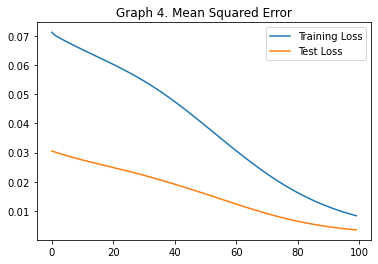

In [33]:
plt.title('Graph 4. Mean Squared Error')
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Test Loss')
plt.legend()
plt.show()

In [34]:
print("MSE for training and test data are both low and converge quickly, indicating that MSE works well as a loss function for our LSTM model.")

MSE for training and test data are both low and converge quickly, indicating that MSE works well as a loss function for our LSTM model.


Run the model.

In [35]:
y_pred = model.predict(X_test_array)

4/4 [==============================] - 1s 6ms/step


Plot predicted vs. actual values.

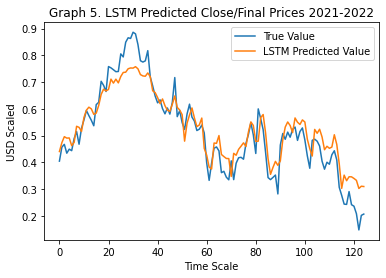

In [36]:
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Predicted Value')
plt.title('Graph 5. LSTM Predicted Close/Final Prices 2021-2022')
plt.xlabel('Time Scale')
plt.ylabel('USD Scaled')
plt.legend()
plt.show()

## Apply LSTM model to predict stock prices in 2023

In [37]:
df_2023 = df[df["Date"].str.contains("2023")]

In [38]:
df_2023 = df_2023.loc[::-1].reset_index(drop=True)
df_2023 = df_2023.set_index(pd.DatetimeIndex(df_2023['Date']))
df_2023['Date'] = pd.to_datetime(df_2023.Date, format="%m/%d/%Y")
df_2023 = df_2023.iloc[:14]

In [39]:
df_2023

,Date,Close/Last,Volume,Open,High,Low
Date,,,,,,
2023-01-03,2023-01-03,125.07,112117500,130.280,130.9000,124.17
2023-01-04,2023-01-04,126.36,89113630,126.890,128.6557,125.08
2023-01-05,2023-01-05,125.02,80962710,127.130,127.7700,124.76
2023-01-06,2023-01-06,129.62,87754720,126.010,130.2900,124.89
2023-01-09,2023-01-09,130.15,70790810,130.465,133.4100,129.89
2023-01-10,2023-01-10,130.73,63896160,130.260,131.2636,128.12
2023-01-11,2023-01-11,133.49,69458950,131.250,133.5100,130.46
2023-01-12,2023-01-12,133.41,71379650,133.880,134.2600,131.44
2023-01-13,2023-01-13,134.76,57809720,132.030,134.9200,131.66


Plot actual values.

<function matplotlib.pyplot.show(close=None, block=None)>

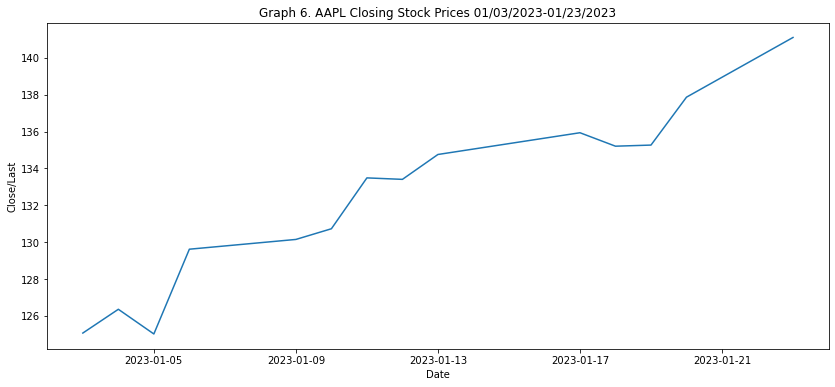

In [40]:
plt.figure(figsize = (14,6))
sns.lineplot(data=df_2023, x="Date", y="Close/Last")
plt.title("Graph 6. AAPL Closing Stock Prices 01/03/2023-01/23/2023")
plt.show

Normalize and reshape 2023 data.

In [41]:
df_2023_scaled = df_2023
for col in df_2023.columns:
    df_2023[col] = MinMaxScaler(feature_range = (0,1)).fit_transform(df_2023[col].to_numpy().reshape(-1,1))

In [42]:
features_2023 = df_2023_scaled[features]
features_2023 = pd.DataFrame(columns=features, data=features_2023, index=df_2023_scaled.index)

In [43]:
X_test2 = np.array(features_2023)
X_test_2023 = X_test2.reshape(X_test2.shape[0], 1, X_test2.shape[1])

In [44]:
y_test_2023 = np.array(df_2023_scaled['Close/Last'])

Run the model.

In [45]:
y_pred_2023 = model.predict(X_test_2023)

1/1 [==============================] - 0s 43ms/step


Plot actual vs. predicted values. :)

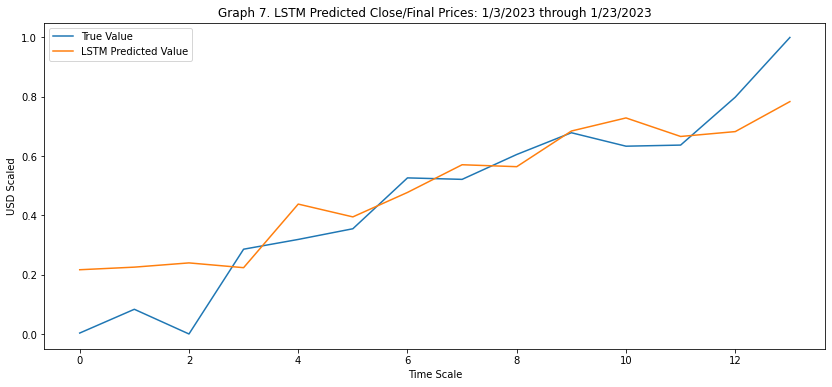

In [46]:
plt.figure(figsize = (14,6))
plt.plot(y_test_2023, label='True Value')
plt.plot(y_pred_2023, label='LSTM Predicted Value')
plt.title('Graph 7. LSTM Predicted Close/Final Prices: 1/3/2023 through 1/23/2023')
plt.xlabel('Time Scale')
plt.ylabel('USD Scaled')
plt.legend()
plt.show()